In [1]:
import astropy
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# FILES

In [2]:
outroot = '/Users/FRANNYPACK/Downloads/grind!/research/Data/'

In [3]:
GASKAP = fits.open(outroot + 'MW_foreground_SMC.fits')
HI4PI = fits.open(outroot + 'SMC_HI4PI/mosaic_cube.fits')

In [4]:
# using catalogue w/o velocities for maximum amount of data

FUSE = pd.read_csv(outroot + 'FUSE_info (SMC + LMC).csv')

In [5]:
FUSE = FUSE[(FUSE["DEC_FK5"] < -69) & (FUSE["Galaxy"] == 'SMC') & (FUSE["RA_FK5"] < 28)] # relevant SMC stars

# RELEVANT FUNCTIONS

In [7]:
# make 2D header 
def make_flat_hdr(file):
    hdr = file[0].header
    
    # Make a 2D header 
    flathdr = fits.Header()
    flathdr["NAXIS   "] = 2
    flathdr["NAXIS1  "] = hdr["NAXIS1  "]
    flathdr["NAXIS2  "] = hdr["NAXIS2  "]
    flathdr["CRPIX1  "] = hdr["CRPIX1  "]
    flathdr["CRPIX2  "] = hdr["CRPIX2  "]
    flathdr["CRVAL1  "] = hdr["CRVAL1  "]
    flathdr["CRVAL2  "] = hdr["CRVAL2  "]
    flathdr["CDELT1  "] = hdr["CDELT1  "]
    flathdr["CDELT2  "] = hdr["CDELT2  "]
    flathdr["CTYPE1  "] = hdr["CTYPE1  "]
    flathdr["CTYPE2  "] = hdr["CTYPE2  "]
    flathdr["LONPOLE "] = hdr["LONPOLE "]
    flathdr["LATPOLE "] = hdr["LATPOLE "]
    
    return flathdr

In [8]:
# gives pix vals associated w RA/DEC vals using FITS header

def pix_vals(flat_FITS_hdr, ra_values, dec_values):
    wcs = WCS(flat_FITS_hdr)
    pix_arr = []
    x_pix = []
    y_pix = []
    for i in range(0, len(ra_values)):
        arr = []
        x_pix, y_pix = wcs.all_world2pix(ra_values[i], dec_values[i], 0)
        arr.append(x_pix)
        arr.append(y_pix)
        pix_arr.append(arr)
    
    return pix_arr

In [15]:
def Tb(pix, tot_arr):
    final_arr = np.zeros(len(pix))
    for i in range(len(pix)):
        final_arr[i] = tot_arr[int(pix[i][1])][int(pix[i][0])]
    return final_arr

In [22]:
# creates grid of (ra, dec) values corresponding to each pixel
def coordinate_4_pix(flat_hdr): 
    NAXIS1 = flat_hdr["NAXIS1"]
    NAXIS2 = flat_hdr["NAXIS2"]
    x = np.arange(NAXIS1)
    y = np.arange(NAXIS2)
    X, Y = np.meshgrid(x, y) # return coordinate matrices from coordinate vectors
    w = WCS(flat_hdr)
    ra, dec = w.wcs_pix2world(X, Y, 0)# turns pixel coordinates into world coordinates
    coords = np.dstack((ra,dec)) # stack arrays in sequence along 3rd axis
    return coords

In [40]:
# plots sketchy pixels on top of channel maps

def loc_pix(arr, coords, vmin = 0, vmax = 20):
    fig = plt.figure(figsize = (12,9))
    im = plt.pcolormesh(coords[:, :, 0], coords[:, :, 1], arr, vmin = vmin, vmax = vmax, cmap = 'magma')
    scatter_pts = plt.scatter(ra, dec, c = c, cmap = 'viridis', s = 120)
    plt.colorbar(im)
    plt.colorbar(scatter_pts)
    plt.xlim(30, 0)

# GETTING HI BRIGHTNESS VALUES AT HI SIGHTLINES

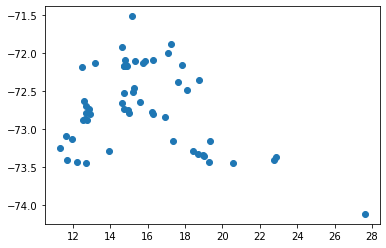

In [9]:
x = FUSE['RA_FK5']
y = FUSE['DEC_FK5']

scatter_pts = plt.scatter(x, y)
ra = scatter_pts.get_offsets()[:,0]
dec = scatter_pts.get_offsets()[:,1] 


In [10]:
GASKAP_flat_hdr = make_flat_hdr(GASKAP)
HI4PI_flat_hdr = make_flat_hdr(HI4PI)

In [11]:
pix = pix_vals(GASKAP_flat_hdr, ra, dec) # pixel values @ H2 sightlines for HI4PI and GASKAP

In [54]:
GASKAP_Tb_sum = np.nansum(GASKAP[0].data, axis = 0)

In [14]:
HI4PI_Tb_sum = np.sum(HI4PI[0].data, axis = 0)

In [16]:
GASKAP_Tb = Tb(pix, GASKAP_Tb_sum)
HI4PI_Tb = Tb(pix, HI4PI_Tb_sum)

In [17]:
# for H2 sightlines
norm_G = np.linalg.norm(GASKAP_Tb)
norm_H = np.linalg.norm(HI4PI_Tb)
GASKAP_Tb_norm = GASKAP_Tb / norm_G
HI4PI_Tb_norm = HI4PI_Tb / norm_H

In [55]:
# for whole cube
GASKAP_Tb_tot = np.nansum(GASKAP_Tb_sum, axis = 1)
HI4PI_Tb_tot = np.sum(HI4PI_Tb_sum, axis = 1)

norm_G_tot = np.linalg.norm(GASKAP_Tb_tot)
norm_H_tot = np.linalg.norm(HI4PI_Tb_tot)
GASKAP_Tb_normtot = GASKAP_Tb_tot / norm_G_tot
HI4PI_Tb_normtot = HI4PI_Tb_tot / norm_H_tot

# THE ACTUAL CORRELATING

In [18]:
# deviations for H2 sightlines specifically
np.correlate(GASKAP_Tb_norm, HI4PI_Tb_norm)

array([0.99629888])

In [57]:
# deviations for ENTIRE cube
# could be inaccurate though b/c GASKAP data has many nan values, whereas HI4PI has none
np.correlate(GASKAP_Tb_normtot, HI4PI_Tb_normtot)

array([0.93316234])

In [28]:
diff = GASKAP_Tb_norm / HI4PI_Tb_norm
print(diff)

[1.06915738 0.94266937 0.94321152 0.97297207 1.04399143 1.08985215
 1.03391333 1.10337633 0.97375528 1.07399918 0.93438611 1.13578761
 0.97355887 0.85925869 0.98555905 1.18160766 0.94932433 0.9592447
 0.84745397 1.00513275 0.88751712 0.97861077 0.90282921 0.8329444
 1.06286275 1.00399405 1.0310619  0.96044443 1.06832049 1.07539798
 0.84933661 0.99108299 0.9477975  1.01701059 0.92057358 1.1341805
 1.05894744 0.94694247 0.93583964 1.04699131 1.04521177 1.02539122
 0.8901852  0.95386862 0.88507328 1.02748409 1.18054615 1.14820934
 0.9653983  0.93500141 1.0675321  0.92704972 0.93563324 0.96232012
 0.88297712 0.93250344 1.05231784]


In [30]:
# values of array where there's over 10% difference between GASKAP and HI4PI
sketchy = np.array([pix[11], pix[15], pix[23], pix[30], pix[35], pix[42], pix[44], pix[46], pix[47], pix[54]])
c = np.array([diff[11], diff[15], diff[23], diff[30], diff[35], diff[42], diff[44], diff[46], diff[47], diff[54]])

ra, dec = WCS(GASKAP_flat_hdr).wcs_pix2world(sketchy[:,0], sketchy[:,1], 0)# from pixel coordinates to world coordinates


# PLOTTING WHERE THESE WACKY POINTS ARE

In [24]:
coords = coordinate_4_pix(GASKAP_flat_hdr)

Interestingly enough, deviations are not concentrated around the border noise

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_56169/2866601164.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(coords[:, :, 0], coords[:, :, 1], arr, vmin = vmin, vmax = vmax, cmap = 'magma')


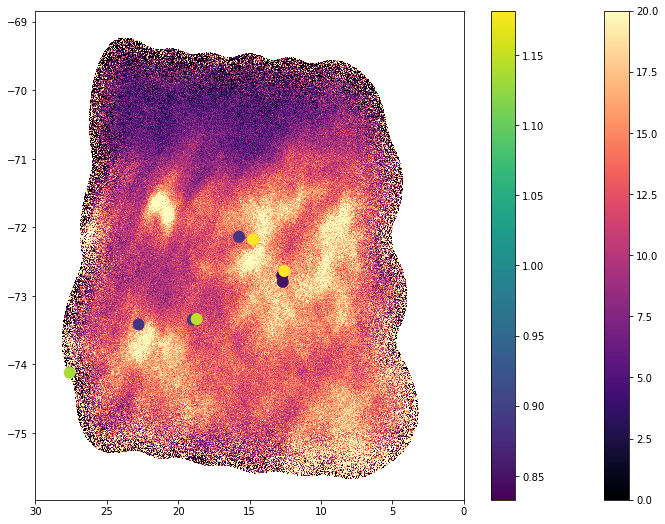

In [41]:
loc_pix(GASKAP[0].data[41,:,:], coords)